In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
ds=pd.read_csv("dataset3.csv")

In [3]:
ds.shape

(1028, 20)

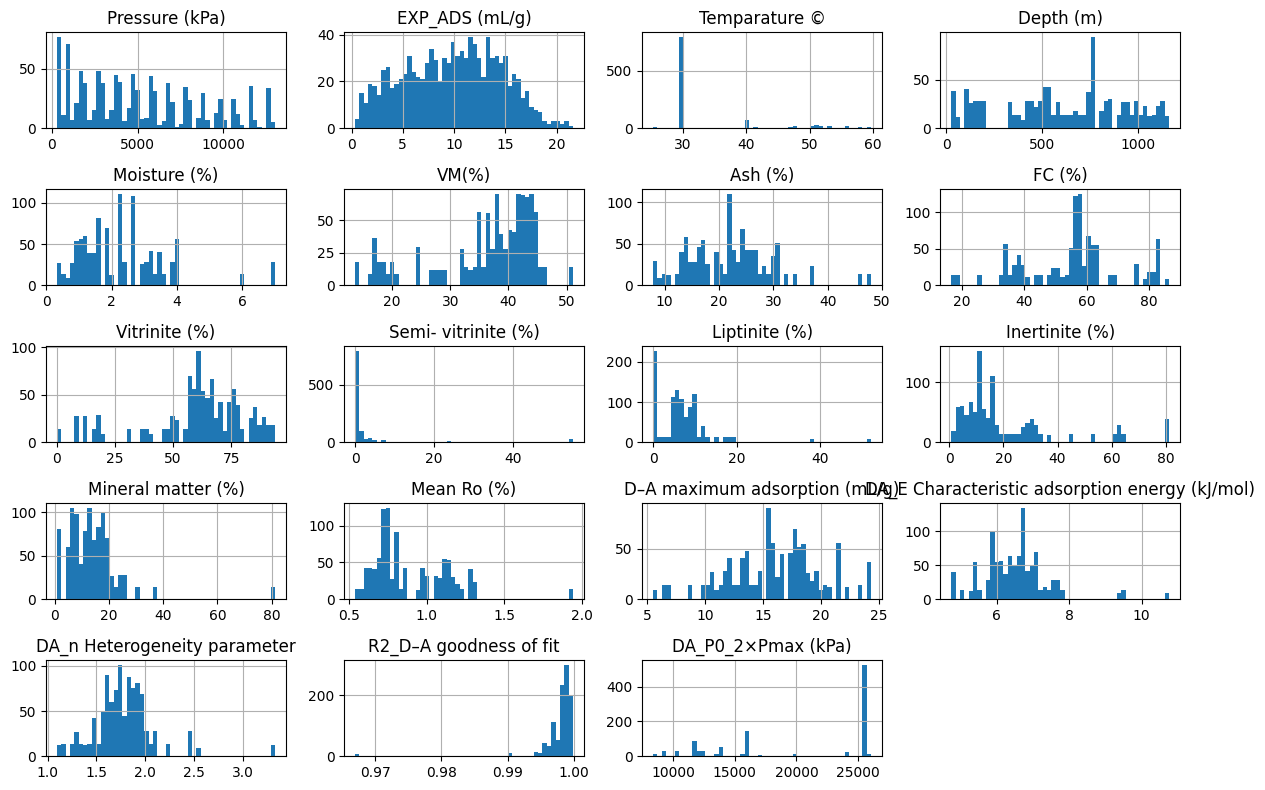

In [4]:
import matplotlib.pyplot as plt

ds.hist(bins=50, figsize=(12,8))
plt.tight_layout()
plt.savefig("ds_hist.png")
plt.show()


In [5]:
print(ds.columns.tolist())

['Sample', 'Pressure (kPa)', 'EXP_ADS (mL/g)', 'Temparature ©', 'Depth (m)', 'Moisture (%)', 'VM(%)', 'Ash (%)', 'FC (%)', 'Vitrinite (%)', 'Semi- vitrinite (%)', 'Liptinite (%)', 'Inertinite (%)', 'Mineral matter (%)', 'Mean Ro (%)', 'D–A maximum adsorption (mL/g)', 'DA_E Characteristic adsorption energy (kJ/mol)', 'DA_n Heterogeneity parameter', 'R2_D–A goodness of fit', 'DA_P0_2×Pmax\u200b (kPa)']


In [6]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Define column groups based on distribution analysis
cols_skewed = [
    'Pressure (kPa)', 'Moisture (%)', 'Semi- vitrinite (%)', 
    'Liptinite (%)', 'Mineral matter (%)', 'DA_P0_2×Pmax\u200b (kPa)'
]

cols_normal = [
    'Ash (%)', 'D–A maximum adsorption (mL/g)', 'DA_n Heterogeneity parameter', 
    'Mean Ro (%)', 'DA_E Characteristic adsorption energy (kJ/mol)'
]

cols_bounded = [
    'Depth (m)', 'VM(%)', 'FC (%)', 'Vitrinite (%)', 'Inertinite (%)'
]

# Columns to drop (IDs or high-correlation/noise columns)
cols_drop = ['Sample', 'Temparature ©', 'R2_D–A goodness of fit']

print("Libraries imported and column groups defined.")

Libraries imported and column groups defined.


In [7]:
# 1. Separate Features (X) and Target (y)
target_col = 'EXP_ADS (mL/g)'
X = ds.drop(columns=[target_col])
y = ds[target_col]

# 2. Define the Preprocessing Pipeline
# Log pipeline for skewed data
log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

# Main Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('skewed', log_pipeline, cols_skewed),
        ('normal', StandardScaler(), cols_normal),
        ('bounded', MinMaxScaler(), cols_bounded),
        ('drop', 'drop', cols_drop)
    ],
    remainder='passthrough', # Keep any other columns not listed
    verbose_feature_names_out=False
)

# 3. Split the data (Train: 70%, Val: 15%, Test: 15%)
# First split: Train vs Temp (Test + Val)
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Second split: Val vs Test
X_val_raw, X_test_raw, y_val, y_test = train_test_split(X_temp_raw, y_temp, test_size=0.5, random_state=42)

# 4. Fit Preprocessor on TRAIN data only (prevents data leakage), then transform all
X_train = preprocessor.fit_transform(X_train_raw)
X_val = preprocessor.transform(X_val_raw)
X_test = preprocessor.transform(X_test_raw)

input_shape = [X_train.shape[1]]

print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (719, 16)
Validation shape: (154, 16)
Testing shape: (155, 16)


In [8]:
def build_simple_mlp(input_shape):
    """A basic network with 2 hidden layers."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1) # Linear output for regression
    ], name="Simple_MLP")
    return model

def build_deep_regularized_mlp(input_shape):
    """Deep network with BatchNormalization and Dropout to prevent overfitting."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ], name="Deep_Regularized_MLP")
    return model

def build_wide_and_deep(input_shape):
    """Combines linear path (wide) with non-linear path (deep)."""
    inputs = layers.Input(shape=input_shape)
    
    # Deep path
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # Wide path: concatenates original inputs with deep features
    combined = layers.concatenate([inputs, x])
    
    outputs = layers.Dense(1)(combined)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Wide_and_Deep")
    return model

print("Model architectures defined.")

Model architectures defined.


In [9]:
# Configuration
BATCH_SIZE = 32
MAX_EPOCHS = 200
results = []

models_to_train = [
    build_simple_mlp(input_shape),
    build_deep_regularized_mlp(input_shape),
    build_wide_and_deep(input_shape)
]

# Early stopping callback (stops training when Val Loss stops improving)
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=20, 
    restore_best_weights=True
)

for model in models_to_train:
    print(f"\nTraining {model.name}...")
    
    model.compile(
        optimizer='adam',
        loss='mae', # Mean Absolute Error is good for regression stability
        metrics=['mse']
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=MAX_EPOCHS,
        callbacks=[early_stopping],
        verbose=0 # Set to 1 to see per-epoch logs
    )
    
    # Predictions
    y_pred = model.predict(X_test).flatten()
    
    # Calculate Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': model.name,
        'MAE': mae,
        'RMSE': rmse,
        'R2 Score': r2,
        'History': history
    })
    
    print(f"Completed. R2 Score: {r2:.4f}")

print("\nAll models trained successfully.")


Training Simple_MLP...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Completed. R2 Score: 0.9966

Training Deep_Regularized_MLP...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Completed. R2 Score: -3.9567

Training Wide_and_Deep...
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000015B90C8C680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━


--- Model Performance on Test Set ---


,Model,MAE,RMSE,R2 Score
0,Simple_MLP,0.177342,0.270719,0.996619
2,Wide_and_Deep,7.110231,8.254585,-2.143710
1,Deep_Regularized_MLP,9.229301,10.365058,-3.956733


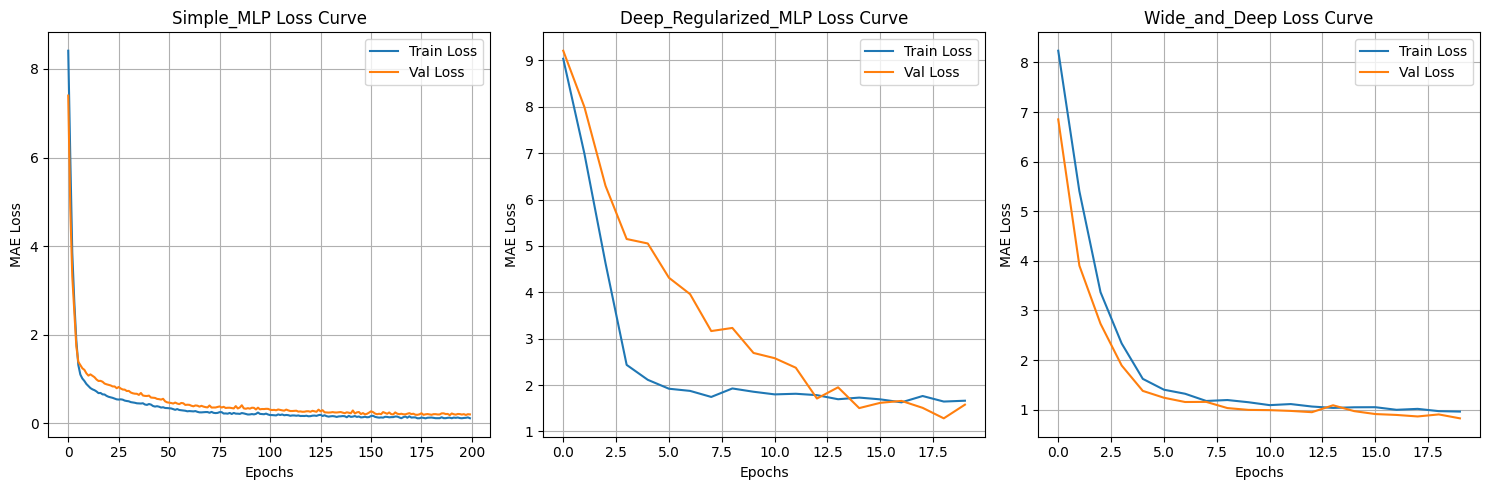

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


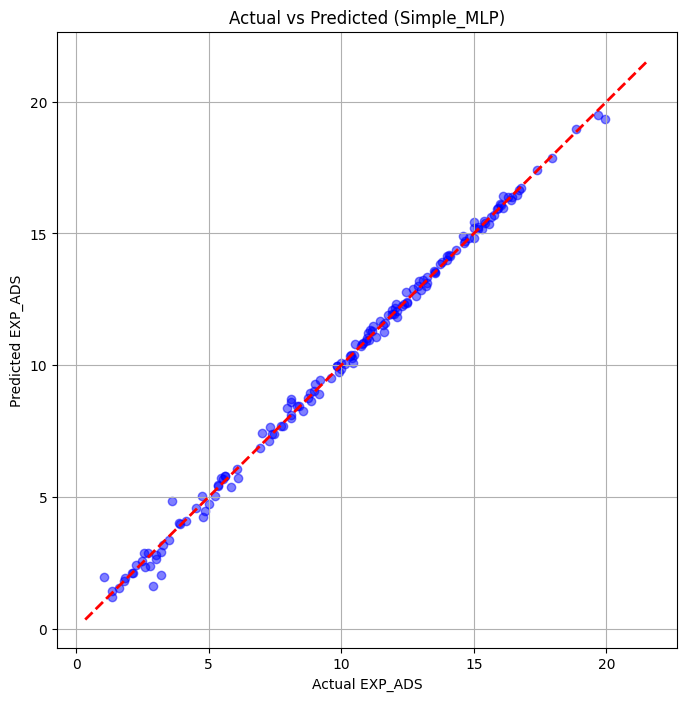

In [10]:
# 1. Comparison DataFrame
df_results = pd.DataFrame(results).drop(columns=['History'])
print("\n--- Model Performance on Test Set ---")
display(df_results.sort_values(by='R2 Score', ascending=False))

# 2. Plotting Training History
plt.figure(figsize=(15, 5))

for i, res in enumerate(results):
    hist = res['History'].history
    name = res['Model']
    
    plt.subplot(1, 3, i+1)
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f"{name} Loss Curve")
    plt.xlabel('Epochs')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Plotting Predictions vs Actuals for Best Model
best_model_idx = df_results['R2 Score'].idxmax()
best_model_name = results[best_model_idx]['Model']
best_model = models_to_train[best_model_idx]

y_pred_best = best_model.predict(X_test).flatten()

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_best, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual EXP_ADS')
plt.ylabel('Predicted EXP_ADS')
plt.title(f'Actual vs Predicted ({best_model_name})')
plt.grid(True)
plt.show()

In [11]:
from sklearn.model_selection import KFold

# Configuration
N_FOLDS = 5
BATCH_SIZE = 16  # Smaller batch size for small dataset
EPOCHS = 150
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Storage for results
cv_results = {
    'Simple_MLP': [],
    'Deep_Regularized': [],
    'Wide_and_Deep': []
}

# Helper to re-build models (fresh weights every fold)
def get_model(name, shape):
    if name == 'Simple_MLP':
        return build_simple_mlp(shape)
    elif name == 'Deep_Regularized':
        # Simplified version of the deep model to help convergence
        model = keras.Sequential([
            layers.Input(shape=shape),
            layers.Dense(64, activation='relu'), # Reduced from 128
            layers.BatchNormalization(),
            layers.Dropout(0.2), # Reduced dropout
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ], name="Deep_Regularized_Simpler")
        return model
    elif name == 'Wide_and_Deep':
        return build_wide_and_deep(shape)

print(f"Starting {N_FOLDS}-Fold Cross-Validation...\n")

X_processed = preprocessor.fit_transform(X) # Transform full dataset for CV
y_values = y.values

fold_no = 1
for train_index, val_index in kf.split(X_processed):
    X_train_fold, X_val_fold = X_processed[train_index], X_processed[val_index]
    y_train_fold, y_val_fold = y_values[train_index], y_values[val_index]
    
    print(f"--- Fold {fold_no} ---")
    
    for model_name in cv_results.keys():
        # 1. Build fresh model
        model = get_model(model_name, [X_processed.shape[1]])
        
        # 2. Compile with lower learning rate for stability
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      loss='mae')
        
        # 3. Train (Silent mode)
        model.fit(
            X_train_fold, y_train_fold,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            callbacks=[callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
        )
        
        # 4. Evaluate
        y_pred = model.predict(X_val_fold, verbose=0).flatten()
        r2 = r2_score(y_val_fold, y_pred)
        cv_results[model_name].append(r2)
        
        print(f"  {model_name}: R2 = {r2:.4f}")
    
    fold_no += 1

print("\nCross-Validation Complete.")

Starting 5-Fold Cross-Validation...

--- Fold 1 ---


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Simple_MLP: R2 = 0.9940


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Deep_Regularized: R2 = 0.9501


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Wide_and_Deep: R2 = 0.9933
--- Fold 2 ---


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Simple_MLP: R2 = 0.9793


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Deep_Regularized: R2 = 0.9385


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Wide_and_Deep: R2 = 0.9734
--- Fold 3 ---


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Simple_MLP: R2 = 0.9953


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Deep_Regularized: R2 = 0.9665


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Wide_and_Deep: R2 = 0.9919
--- Fold 4 ---


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Simple_MLP: R2 = 0.9965


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Deep_Regularized: R2 = 0.9876


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Wide_and_Deep: R2 = 0.9957
--- Fold 5 ---


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Simple_MLP: R2 = 0.9970


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Deep_Regularized: R2 = 0.9848


C:\Users\susmi\OneDrive\Desktop\AI_ML\tf-env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


  Wide_and_Deep: R2 = 0.9956

Cross-Validation Complete.


--- Final K-Fold Cross-Validation Results ---


,Model,Mean R2,Std Dev R2,Min R2,Max R2
0,Simple_MLP,0.992411,0.006648,0.979274,0.996985
2,Wide_and_Deep,0.989955,0.008418,0.973363,0.995678
1,Deep_Regularized,0.965490,0.019117,0.938480,0.987606


C:\Users\susmi\AppData\Local\Temp\ipykernel_12232\4019536506.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_results.values(), labels=cv_results.keys(), patch_artist=True)


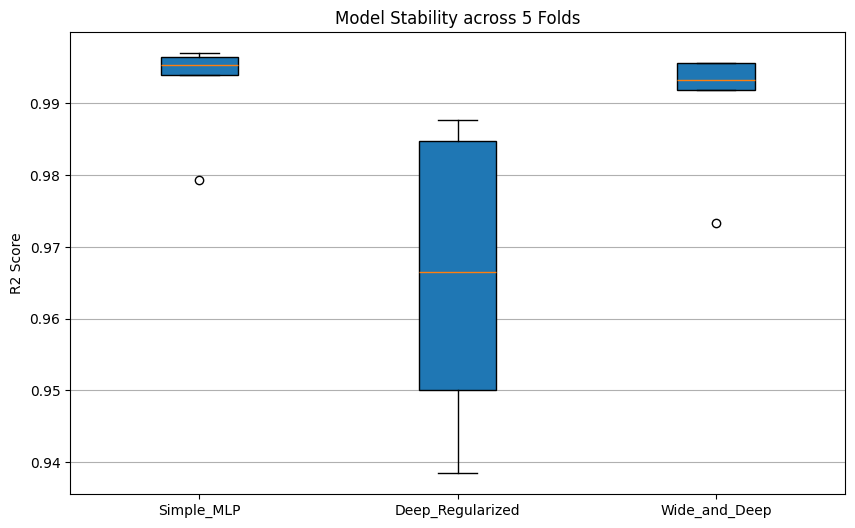


✅ The Best Fair Model is: Simple_MLP
It achieved an average R2 of 0.9924 with stability of ±0.0066
Training final Simple_MLP on 100% of data...
Model saved to disk.


In [12]:
# 1. Aggregate Results
final_stats = []

for name, scores in cv_results.items():
    final_stats.append({
        'Model': name,
        'Mean R2': np.mean(scores),
        'Std Dev R2': np.std(scores),
        'Min R2': np.min(scores),
        'Max R2': np.max(scores)
    })

df_cv = pd.DataFrame(final_stats).sort_values(by='Mean R2', ascending=False)

print("--- Final K-Fold Cross-Validation Results ---")
display(df_cv)

# 2. Visual Comparison
plt.figure(figsize=(10, 6))
plt.boxplot(cv_results.values(), labels=cv_results.keys(), patch_artist=True)
plt.title(f'Model Stability across {N_FOLDS} Folds')
plt.ylabel('R2 Score')
plt.grid(True, axis='y')
plt.show()

# 3. Save the Best Model
best_model_name = df_cv.iloc[0]['Model']
print(f"\n✅ The Best Fair Model is: {best_model_name}")
print(f"It achieved an average R2 of {df_cv.iloc[0]['Mean R2']:.4f} with stability of ±{df_cv.iloc[0]['Std Dev R2']:.4f}")

# Train one final instance of the winner on ALL data
print(f"Training final {best_model_name} on 100% of data...")
final_model = get_model(best_model_name, [X_processed.shape[1]])
final_model.compile(optimizer='adam', loss='mae')
final_model.fit(X_processed, y_values, epochs=200, batch_size=32, verbose=0)
final_model.save(f"best_coal_model_{best_model_name}.keras")
print("Model saved to disk.")

Computing Permutation Importance... (This may take a minute)


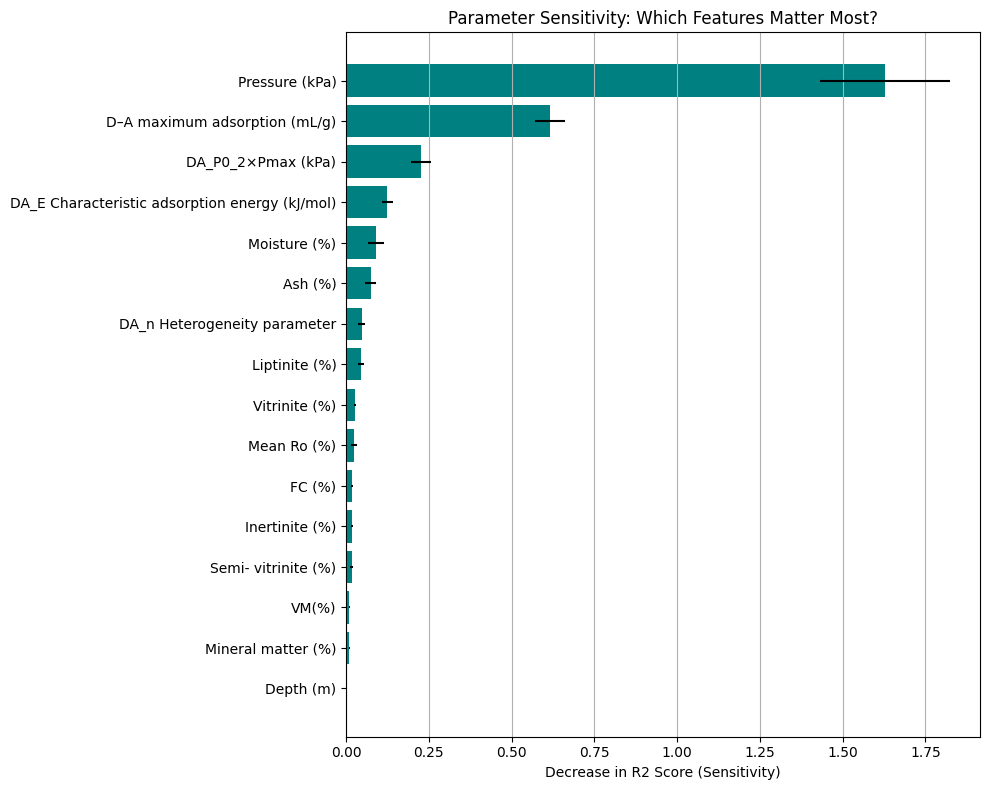

Top 5 Most Sensitive Parameters:
                                           Feature  Importance_Mean  \
0                                   Pressure (kPa)         1.628462   
7                    D–A maximum adsorption (mL/g)         0.616770   
5                              DA_P0_2×Pmax​ (kPa)         0.226216   
10  DA_E Characteristic adsorption energy (kJ/mol)         0.123907   
1                                     Moisture (%)         0.089994   

    Importance_Std  
0         0.195375  
7         0.045797  
5         0.028865  
10        0.016677  
1         0.025304  


In [13]:
from sklearn.inspection import permutation_importance

# 1. FIX: Re-define the pipeline with feature_names_out='one-to-one'
# This tells the FunctionTransformer to pass the input feature names through to the output
log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=True, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

# 2. Re-build the Preprocessor with the corrected pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('skewed', log_pipeline, cols_skewed),
        ('normal', StandardScaler(), cols_normal),
        ('bounded', MinMaxScaler(), cols_bounded),
        ('drop', 'drop', cols_drop)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# 3. Re-fit Preprocessor and Re-transform Data
# We need to re-fit so the preprocessor learns the feature names
preprocessor.fit(X_train_raw) 
X_test_new = preprocessor.transform(X_test_raw)

# 4. Define Scoring and Wrapper (Same as before)
def score_model(estimator, X, y):
    y_pred = estimator.predict(X).flatten()
    return r2_score(y, y_pred)

class KerasWrapper:
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.model.predict(X, verbose=0)

wrapped_model = KerasWrapper(final_model)

print("Computing Permutation Importance... (This may take a minute)")

# 5. Calculate Importance using the NEW X_test_new
results = permutation_importance(
    wrapped_model, 
    X_test_new, 
    y_test, 
    n_repeats=10, 
    random_state=42, 
    scoring=score_model
)

# 6. Process and Plot Results
# Now preprocessor.get_feature_names_out() will work correctly
importance_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Importance_Mean': results.importances_mean,
    'Importance_Std': results.importances_std
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance_Mean', ascending=True)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance_Mean'], xerr=importance_df['Importance_Std'], color='teal')
plt.xlabel('Decrease in R2 Score (Sensitivity)')
plt.title('Parameter Sensitivity: Which Features Matter Most?')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

print("Top 5 Most Sensitive Parameters:")
print(importance_df.sort_values(by='Importance_Mean', ascending=False).head(5))

Success! Found 'Pressure (kPa)' at index 0


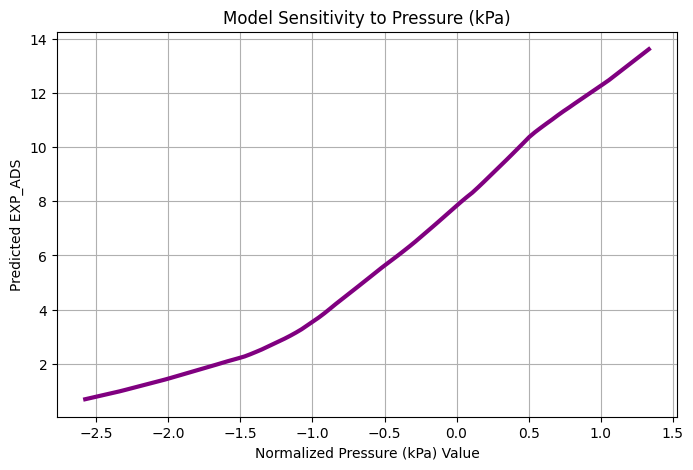

In [14]:
# 1. CORRECTED: Use the exact name from your error message
target_feature = 'Pressure (kPa)' 

# Get the index of this feature in the processed matrix
feature_names = preprocessor.get_feature_names_out()

try:
    feature_idx = list(feature_names).index(target_feature)
    print(f"Success! Found '{target_feature}' at index {feature_idx}")
except ValueError:
    # Fallback if the name is still wrong
    print(f"Error: '{target_feature}' not found.")
    print(f"Available features are: {list(feature_names)}")
    feature_idx = 0 

# 2. Run the Sensitivity Analysis
# Create a baseline row (mean of all data)
baseline_row = X_processed.mean(axis=0).reshape(1, -1)

# Sweep from min to max value seen in training
min_val = X_processed[:, feature_idx].min()
max_val = X_processed[:, feature_idx].max()
sweep_values = np.linspace(min_val, max_val, 100)

predictions = []
for val in sweep_values:
    # Copy baseline
    temp_row = baseline_row.copy()
    # Perturb the specific feature
    temp_row[0, feature_idx] = val
    
    # Predict
    pred = final_model.predict(temp_row, verbose=0)
    predictions.append(pred[0][0])

# 3. Plot
plt.figure(figsize=(8, 5))
plt.plot(sweep_values, predictions, color='purple', lw=3)
plt.title(f'Model Sensitivity to {target_feature}')
plt.xlabel(f'Normalized {target_feature} Value')
plt.ylabel('Predicted EXP_ADS')
plt.grid(True)
plt.show()

we shall try using the ensembling methods with gradient boosting algorithms and the hero XGBoost

In [15]:
# ===============================
# CELL 1 — SCALED DATA TRAINING
# ===============================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

# -------- Scaling --------
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled  = X_test

# -------- Models --------
models_scaled = {
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    "SimpleMLP": MLPRegressor(hidden_layer_sizes=(64, 32),
                              activation='relu',
                              max_iter=1000,
                              random_state=42)
}

results_scaled = {}

for name, model in models_scaled.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    results_scaled[name] = {"R2": r2, "RMSE": rmse}

results_scaled_df = pd.DataFrame(results_scaled).T
print("Performance on SCALED data:")
display(results_scaled_df.sort_values("R2", ascending=False))


Performance on SCALED data:


,R2,RMSE
SimpleMLP,0.996821,0.262475
GradientBoosting,0.989157,0.484789
XGBoost,0.982896,0.608867
RandomForest,0.968948,0.820381


In [16]:
# ===============================
# CELL 2 — RAW DATA TRAINING
# ===============================

models_raw = {
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    "SimpleMLP": MLPRegressor(hidden_layer_sizes=(64, 32),
                              activation='relu',
                              max_iter=1000,
                              random_state=42)
}

results_raw = {}

for name, model in models_raw.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    results_raw[name] = {"R2": r2, "RMSE": rmse}

results_raw_df = pd.DataFrame(results_raw).T
print("Performance on RAW data:")
display(results_raw_df.sort_values("R2", ascending=False))


# ===============================
# COMPARISON
# ===============================

print("\nBest Model (Scaled):")
print(results_scaled_df.sort_values("R2", ascending=False).head(1))

print("\nBest Model (Raw):")
print(results_raw_df.sort_values("R2", ascending=False).head(1))


# Decide global best
best_scaled = results_scaled_df.sort_values("R2", ascending=False).iloc[0]
best_raw = results_raw_df.sort_values("R2", ascending=False).iloc[0]

if best_scaled["R2"] > best_raw["R2"]:
    print("\n✅ Final Winner: SCALED DATA MODEL")
else:
    print("\n✅ Final Winner: RAW DATA MODEL")


Performance on RAW data:


,R2,RMSE
SimpleMLP,0.996821,0.262475
GradientBoosting,0.989157,0.484789
XGBoost,0.982896,0.608867
RandomForest,0.968948,0.820381



Best Model (Scaled):
                 R2      RMSE
SimpleMLP  0.996821  0.262475

Best Model (Raw):
                 R2      RMSE
SimpleMLP  0.996821  0.262475

✅ Final Winner: RAW DATA MODEL
